In [1]:
# A better way to read the same file, handling BOM and end-of-line truncation

import re
import pandas as pd
from pathlib import Path

path = "arrets_ben.csv"
out_parquet = "arrets_ben.parquet"

# --- 1) Read header + dash line, remove BOM automatically ---
with open(path, encoding="utf-8-sig") as f:
    header_line = f.readline().rstrip("\n")
    dash_line   = f.readline().rstrip("\n")

# --- 2) Infer column spans from runs of dashes ---
colspecs = [(m.start(), m.end()) for m in re.finditer(r"-+", dash_line)]

# Make the last column go to end-of-line to avoid truncation
colspecs[-1] = (colspecs[-1][0], None)

# --- 3) Slice column names from the (BOM-stripped) header ---
raw_names = [header_line[s:] if e is None else header_line[s:e] for s, e in colspecs]
names = []
seen = {}
for nm in map(str.strip, raw_names):
    seen[nm] = seen.get(nm, -1) + 1
    names.append(nm if seen[nm] == 0 else f"{nm}_{seen[nm]}")

print("Detected columns:", len(names))
print(names[:10], "...")

# --- 4) Read the data as fixed-width (skip header + dashes) ---
df = pd.read_fwf(
    path,
    colspecs=colspecs,
    names=names,
    skiprows=2,
    na_values=["NULL"],
    encoding="utf-8-sig",
)
print(df.shape)
print(df.head(3))

FileNotFoundError: [Errno 2] No such file or directory: 'arrets_ben.csv'

### Build Segment

In [2]:
# ===== CHUNK 1: build seg (strict window-anchor; no backups) =====
import numpy as np
import pandas as pd

# （假設 df 已讀入）
if "C_TypeAppl" in df.columns:
    df = df[df["C_TypeAppl"] == 0]  # commercial only

seg_src = df.copy()

# -- 時間欄位轉型（存在才轉） --
time_cols = [
    "DTDepartTheo","DTArriveeTheo",
    "DTEntreeFenetreArretReal","DTSortieFenetreArretReal",
    "DTEntreeArretAtp","DTSortieArretAtp",
    "DTMarquageArretTheo","DTMarquageArretReal",
    "HOuverturePortesReal","HFermetureportesReal"
]
for c in time_cols:
    if c in seg_src.columns:
        seg_src[c] = pd.to_datetime(seg_src[c], errors="coerce")

# -- 基本數值/字串清理 --
if "RangArretAsc" in seg_src.columns:
    seg_src["RangArretAsc"] = pd.to_numeric(seg_src["RangArretAsc"], errors="coerce")
if "C_Ligne" in seg_src.columns:
    seg_src["C_Ligne"] = pd.to_numeric(seg_src["C_Ligne"], errors="coerce")

seg_src["CodeLong"] = seg_src.get("CodeLong","").astype(str).str.strip()
if "C_SensAppl" in seg_src.columns:
    seg_src["C_SensAppl"] = seg_src["C_SensAppl"].astype(str).str.strip()

# 需求/距離/實測時間等轉數值
for c in ["DistanceInterArret","TempsInterArretRealise","EcartDepart","NbMontees","NbDescentes"]:
    if c in seg_src.columns:
        seg_src[c] = pd.to_numeric(seg_src[c], errors="coerce")

# -- 依行程排序並建立「上一站」資訊 --
by = ["IdCourse","RangArretAsc"] if "IdCourse" in seg_src.columns else ["C_Ligne","DateCourse","RangArretAsc"]
seg_src = seg_src.sort_values(by, kind="mergesort")
grp = seg_src.groupby("IdCourse") if "IdCourse" in seg_src.columns else seg_src.groupby(["C_Ligne","DateCourse"])

seg_src["prev_CodeLong"] = grp["CodeLong"].shift(1)

# 上一站 window in/out（嚴格：僅用 window）
if {"DTEntreeFenetreArretReal","DTSortieFenetreArretReal"}.issubset(seg_src.columns):
    seg_src["prev_DT_win_out"] = grp["DTSortieFenetreArretReal"].shift(1)
    seg_src["prev_DT_win_in"]  = grp["DTEntreeFenetreArretReal"].shift(1)
else:
    seg_src["prev_DT_win_out"] = np.nan
    seg_src["prev_DT_win_in"]  = np.nan

# 上游需求（作為可用特徵）
if "NbMontees" in seg_src.columns:
    seg_src["prev_NbMontees"] = grp["NbMontees"].shift(1)
if "NbDescentes" in seg_src.columns:
    seg_src["prev_NbDescentes"] = grp["NbDescentes"].shift(1)

# -- 只留有上一站的 row，形成 inter-stop seg --
seg = seg_src.dropna(subset=["prev_CodeLong"]).copy()
seg["from_stop"]   = seg["prev_CodeLong"].astype(str).str.strip()
seg["to_stop"]     = seg["CodeLong"].astype(str).str.strip()
seg["SegmentKey"]  = seg["from_stop"] + "→" + seg["to_stop"]
seg["line"]        = seg.get("C_Ligne").astype("Int64").astype(str) if "C_Ligne" in seg.columns else "NA"
seg["dir"]         = seg.get("C_SensAppl","NA").astype(str)

# -- 目標（單一來源）--
seg["link_s"] = seg.get("TempsInterArretRealise")                     # 實測段行駛
seg.loc[(seg["link_s"]<=0) | (seg["link_s"]>1800), "link_s"] = np.nan # QC：秒，>30min 視為無效

if {"DTEntreeFenetreArretReal","DTSortieFenetreArretReal"}.issubset(seg.columns):
    seg["dwell_s"] = (seg["DTSortieFenetreArretReal"] - seg["DTEntreeFenetreArretReal"]).dt.total_seconds()
    seg.loc[(seg["dwell_s"]<0) | (seg["dwell_s"]>900), "dwell_s"] = np.nan  # QC：<0 或 >15min
else:
    seg["dwell_s"] = np.nan

# -- 上游 dwell 與距離 --
seg["dwell_prev_s"] = (seg["prev_DT_win_out"] - seg["prev_DT_win_in"]).dt.total_seconds()
seg.loc[(seg["dwell_prev_s"]<0) | (seg["dwell_prev_s"]>900), "dwell_prev_s"] = np.nan

seg["distance_m"] = pd.to_numeric(seg.get("DistanceInterArret"), errors="coerce")
seg.loc[seg["distance_m"]<=0, "distance_m"] = np.nan

# -- 嚴格時間錨：僅 prev_DT_win_out --
seg["link_start_time"] = seg["prev_DT_win_out"]
seg = seg[pd.notna(seg["link_start_time"])].copy()

# -- 週期特徵 --
seg["hour"]       = seg["link_start_time"].dt.hour
seg["dow"]        = seg["link_start_time"].dt.dayofweek     # 0=Mon..6=Sun
seg["is_weekend"] = seg["dow"].isin([5,6]).astype(int)
seg["hour_sin"]   = np.sin(2*np.pi*seg["hour"]/24.0)
seg["hour_cos"]   = np.cos(2*np.pi*seg["hour"]/24.0)
seg["period168"]  = seg["dow"]*24 + seg["hour"]


# 1) minute-of-hour（baseline 沒用到 minute，這常常能抓到尖峰邊緣效應）
seg["minute"]     = seg["link_start_time"].dt.minute
seg["minute_sin"] = np.sin(2*np.pi*seg["minute"]/60.0)
seg["minute_cos"] = np.cos(2*np.pi*seg["minute"]/60.0)

# 2) 上游準點（若有 EcartDepart，單位秒；嚴格用上一站的 E）
if "EcartDepart" in seg_src.columns:
    seg_src["prev_EcartDepart"] = grp["EcartDepart"].shift(1)
    seg["E_prev"] = pd.to_numeric(seg_src.loc[seg.index, "prev_EcartDepart"], errors="coerce")
else:
    seg["E_prev"] = np.nan

# 3) headway（同 line+dir+from_stop；上一班在同一 from_stop 的出窗時間差（秒））
key = ["line","dir","from_stop"]
seg = seg.sort_values(key + ["link_start_time"], kind="mergesort").copy()
seg["prev_dep_same_stop"] = seg.groupby(key)["link_start_time"].shift(1)
seg["headway_s"] = (seg["link_start_time"] - seg["prev_dep_same_stop"]).dt.total_seconds()
# 合理範圍（去掉負值與極端值；可依資料調整）
seg.loc[seg["headway_s"] < 0, "headway_s"] = np.nan
seg.loc[seg["headway_s"] > 3600, "headway_s"] = np.nan  # >60min 異常視為缺失

# -- 需求特徵（模型用）--
#   * 上游（可在出站當下可得）→ 推薦用於預測
seg["board_prev"]  = pd.to_numeric(seg.get("prev_NbMontees"),   errors="coerce")
seg["alight_prev"] = pd.to_numeric(seg.get("prev_NbDescentes"), errors="coerce")

#   * （可選）當站需求（多半屬於事後觀測，若你要純 ex-ante 預測，請勿使用）
seg["board_i"]  = pd.to_numeric(seg.get("NbMontees"),   errors="coerce")
seg["alight_i"] = pd.to_numeric(seg.get("NbDescentes"), errors="coerce")

# 你後續可以的特徵清單（ex-ante 安全用）：
feat_cols_exante = [
    "distance_m","dwell_prev_s",
    "board_prev","alight_prev",
    "hour_sin","hour_cos","dow","is_weekend",
    "from_stop","to_stop","line","dir"
]

print(f"[seg] rows kept (strict window anchor): {len(seg):,}")
print("Example ex-ante features:", feat_cols_exante)
print("Targets coverage:",
      f"link_s={seg['link_s'].notna().mean():.1%}, dwell_s={seg['dwell_s'].notna().mean():.1%}")

/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_83980/786228130.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  seg_src[c] = pd.to_datetime(seg_src[c], errors="coerce")
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_83980/786228130.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  seg_src[c] = pd.to_datetime(seg_src[c], errors="coerce")


[seg] rows kept (strict window anchor): 2,135,313
Example ex-ante features: ['distance_m', 'dwell_prev_s', 'board_prev', 'alight_prev', 'hour_sin', 'hour_cos', 'dow', 'is_weekend', 'from_stop', 'to_stop', 'line', 'dir']
Targets coverage: link_s=100.0%, dwell_s=100.0%


In [3]:
# ===== CHUNK 2: time split + empirical baselines =====
import numpy as np
import pandas as pd

# 時間切分（調整成你的 train/test 區間）
TRAIN_FROM = "2024-10-01"
TRAIN_TO   = "2024-10-31"
TEST_FROM  = "2024-11-01"
TEST_TO    = "2024-11-30"

mask_tr = (seg["link_start_time"]>=pd.to_datetime(TRAIN_FROM)) & (seg["link_start_time"]<=pd.to_datetime(TRAIN_TO))
mask_te = (seg["link_start_time"]>=pd.to_datetime(TEST_FROM))  & (seg["link_start_time"]<=pd.to_datetime(TEST_TO))
train = seg[mask_tr].copy()
test  = seg[mask_te].copy()

# baseline 分層層級（可依資料量增減）
LEVELS = [
    ["SegmentKey","period168"],   # 段×168
    # ["SegmentKey","is_weekend","hour"],
    # ["SegmentKey"],
]
MIN_N = 10

def _fit_level_quantile(train_df, target, by, q):
    g = (train_df.dropna(subset=[target])
         .groupby(by)[target]
         .agg(n="size", q=lambda s: float(s.quantile(q))))
    g = g[g["n"]>=MIN_N].reset_index()
    return g

def fit_maps(train_df, target, levels, q):
    maps = [_fit_level_quantile(train_df, target, by, q) for by in levels]
    global_q = float(train_df[target].dropna().quantile(q)) if train_df[target].notna().any() else 0.0
    return maps, global_q

def apply_maps(apply_df, levels, maps, global_q):
    pred  = pd.Series(np.nan, index=apply_df.index, dtype=float)
    remain = pred.isna()
    for i, by in enumerate(levels):
        if len(maps[i])==0 or not remain.any(): 
            continue
        tmp = (apply_df.loc[remain, by].merge(maps[i], on=by, how="left")["q"])
        hit = tmp.notna().values
        pred.loc[remain[remain].index[hit]] = tmp[hit].values
        remain = pred.isna()
    pred.loc[remain] = global_q
    return pred.values

# 擬合 train-map（p50/p85），套用到 train & test
mapsL50, gL50 = fit_maps(train, "link_s", LEVELS, 0.50)
mapsL85, gL85 = fit_maps(train, "link_s", LEVELS, 0.85)
mapsD50, gD50 = fit_maps(train, "dwell_s", LEVELS, 0.50)
mapsD85, gD85 = fit_maps(train, "dwell_s", LEVELS, 0.85)

train["base_link_p50"]  = apply_maps(train, LEVELS, mapsL50, gL50)
train["base_link_p85"]  = apply_maps(train, LEVELS, mapsL85, gL85)
test["base_link_p50"]   = apply_maps(test,  LEVELS, mapsL50, gL50)
test["base_link_p85"]   = apply_maps(test,  LEVELS, mapsL85, gL85)

train["base_dwell_p50"] = apply_maps(train, LEVELS, mapsD50, gD50)
train["base_dwell_p85"] = apply_maps(train, LEVELS, mapsD85, gD85)
test["base_dwell_p50"]  = apply_maps(test,  LEVELS, mapsD50, gD50)
test["base_dwell_p85"]  = apply_maps(test,  LEVELS, mapsD85, gD85)

# 指標 helper
def mae(a, b):
    a = np.asarray(a, float); b = np.asarray(b, float)
    m = np.isfinite(a) & np.isfinite(b)
    return float(np.mean(np.abs(a[m] - b[m]))) if m.any() else np.nan

def coverage(y, qhat):
    y = np.asarray(y, float); qhat = np.asarray(qhat, float)
    m = np.isfinite(y) & np.isfinite(qhat)
    return float(np.mean(y[m] <= qhat[m])) if m.any() else np.nan

In [4]:
# ===== CHUNK 3: residual dataset + features =====

# 殘差（以 link 為主）
train["y_res"] = train["link_s"] - train["base_link_p50"]
test["y_res"]  = test["link_s"]  - test["base_link_p50"]

# 可選：做「每 100m 殘差」版本（跨段更穩）
def _sec_per_100m(x, d): return x / (d/100.0)
def _from_per100m(x, d): return x * (d/100.0)

train["y_res_100m"] = np.where(train["distance_m"]>0, _sec_per_100m(train["y_res"], train["distance_m"]), np.nan)
test["y_res_100m"]  = np.where(test["distance_m"]>0,  _sec_per_100m(test["y_res"],  test["distance_m"]),  np.nan)

# 嚴格外生特徵（避免把 baseline 已學到的路段/週期再學一次）
FEATS_STRICT = [
    "distance_m","dwell_prev_s","board_prev","alight_prev","is_weekend",
    "E_prev",          # 上游準點
    "headway_s",       # 班距
    "minute_sin","minute_cos",  # 分鐘內週期
]
# 若想吸一點殘餘週期，可切換：
FEATS_WITH_TIME = FEATS_STRICT + ["hour_sin","hour_cos"]

USE_FEATS = FEATS_STRICT  # 先用嚴格版本

from sklearn.impute import SimpleImputer

def prep_Xy(df, feats, ycol):
    X = df[feats].copy()
    y = pd.to_numeric(df[ycol], errors="coerce")
    m = y.notna()
    X, y = X.loc[m], y.loc[m]

    # 缺失旗標
    miss_flags = X.isna().add_suffix("__isna").astype(int)

    # 中位數補值（對 skewed 的需求/時間類型更穩）
    imp = SimpleImputer(strategy="median")
    X_imp = pd.DataFrame(imp.fit_transform(X), columns=feats, index=X.index)

    X_final = pd.concat([X_imp, miss_flags.loc[X_imp.index]], axis=1)
    return X_final, y

# 兩種 y 取其一： "y_res" 或 "y_res_100m"
TARGET_COL = "y_res"   # 若要用每100m版本，改成 "y_res_100m"

Xtr, ytr = prep_Xy(train, USE_FEATS, TARGET_COL)
Xte, yte = prep_Xy(test,  USE_FEATS, TARGET_COL)

In [ ]:
from interpret.glassbox import ExplainableBoostingRegressor
from joblib import parallel_backend
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

ebm = ExplainableBoostingRegressor(
    interactions=0,       # 先設 0（純 GAM）
    outer_bags=4,
    learning_rate=0.05,   # 稍微大一點，加速收斂
    max_bins=256,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=1
)
with parallel_backend("threading", n_jobs=1):
    ebm.fit(Xtr, ytr)

pred_res = ebm.predict(Xte)
if TARGET_COL == "y_res_100m":
    dist = test.loc[Xte.index,"distance_m"].to_numpy(float)
    pred_res = _from_per100m(pred_res, dist)
pred_link = test.loc[Xte.index,"base_link_p50"].to_numpy(float) + pred_res

base_mae  = mae(test.loc[Xte.index,"link_s"], test.loc[Xte.index,"base_link_p50"])
model_mae = mae(test.loc[Xte.index,"link_s"], pred_link)
print(f"Baseline p50 MAE: {base_mae:.3f} s")
print(f"GAM (baseline + residual) MAE: {model_mae:.3f} s")
print(f"ΔMAE: {base_mae - model_mae:.3f} s")

Baseline p50 MAE: 16.834 s
GAM (baseline + residual) MAE: 17.112 s
ΔMAE: -0.278 s


In [ ]:
# 重要度（GAM: term_importances_；也可看 each feature 的 shape）

global_exp = ebm.explain_global()
data = global_exp.data()
term_names = data["names"]     # 每個 term（單一特徵或交互）的名稱
term_scores = data["scores"]   # 對應的重要度（越大越重要）

import pandas as pd
imp = pd.Series(term_scores, index=term_names).sort_values(ascending=False)
print("\n[GAM/EBM] Term importance:\n", imp)


[GAM/EBM] Term importance:
 dwell_prev_s          3.891791
distance_m            2.026099
board_prev            1.209464
E_prev                0.984514
headway_s             0.388868
minute_sin            0.209584
minute_cos            0.205398
is_weekend            0.202177
alight_prev           0.139277
dwell_prev_s__isna    0.093250
headway_s__isna       0.088670
distance_m__isna      0.062443
alight_prev__isna     0.000000
is_weekend__isna      0.000000
E_prev__isna          0.000000
board_prev__isna      0.000000
minute_sin__isna      0.000000
minute_cos__isna      0.000000
dtype: float64


In [ ]:
# ===== CHUNK 4: EBM residual model =====
from interpret.glassbox import ExplainableBoostingRegressor
from joblib import parallel_backend
import os, pandas as pd

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

ebm = ExplainableBoostingRegressor(
    interactions=8,        # 若要更像 GAM，可設 0
    outer_bags=4,
    learning_rate=0.02,
    max_bins=256,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=1               # 關閉多進程以避開 numpy 2 相容性雷
)

with parallel_backend("threading", n_jobs=1):
    ebm.fit(Xtr, ytr)

# 殘差預測
pred_res = ebm.predict(Xte)

if TARGET_COL == "y_res_100m":
    dist = test.loc[Xte.index,"distance_m"].to_numpy(float)
    pred_res = _from_per100m(pred_res, dist)

# 最終 link_s 預測 = baseline p50 + 殘差
pred_link = test.loc[Xte.index,"base_link_p50"].to_numpy(float) + pred_res

# 指標：baseline vs model
base_mae  = mae(test.loc[Xte.index,"link_s"], test.loc[Xte.index,"base_link_p50"])
model_mae = mae(test.loc[Xte.index,"link_s"], pred_link)
print(f"Baseline p50 MAE: {base_mae:.3f} s")
print(f"EBM (baseline + residual) MAE: {model_mae:.3f} s")
print(f"ΔMAE (improvement): {base_mae - model_mae:.3f} s")

# ---- 重要度（正確做法）----
gexp = ebm.explain_global()
gdat = gexp.data()  # {'type': 'univariate', 'names': [...], 'scores': [...], ...}

# 1) term-level 重要度（含單變量 + 交互）
term_importance = pd.Series(gdat["scores"], index=gdat["names"]).sort_values(ascending=False)
print("\n[EBM] Term importance (all terms):")
print(term_importance)

# 2) 只看「單一特徵」的重要度（更像 feature importance）
single_idx = [i for i, feats in enumerate(ebm.term_features_) if len(feats) == 1]
single_names  = [gdat["names"][i]  for i in single_idx]
single_scores = [gdat["scores"][i] for i in single_idx]
feat_importance = pd.Series(single_scores, index=single_names).sort_values(ascending=False)
print("\n[EBM] Single-feature importance:")
print(feat_importance)


Baseline p50 MAE: 16.817 s
EBM (baseline + residual) MAE: 16.918 s
ΔMAE (improvement): -0.101 s

[EBM] Term importance (all terms):
dwell_prev_s                  0.681679
distance_m                    0.451916
distance_m & dwell_prev_s     0.245039
alight_prev                   0.123654
is_weekend                    0.111110
board_prev                    0.105475
distance_m & alight_prev      0.101228
distance_m & board_prev       0.098480
dwell_prev_s & board_prev     0.055290
dwell_prev_s & alight_prev    0.051304
distance_m & is_weekend       0.048120
dwell_prev_s & is_weekend     0.025877
board_prev & alight_prev      0.021915
dtype: float64

[EBM] Single-feature importance:
dwell_prev_s    0.681679
distance_m      0.451916
alight_prev     0.123654
is_weekend      0.111110
board_prev      0.105475
dtype: float64


In [ ]:
print("train/test rows:", len(train), len(test))
print("Xtr/Xte rows:", len(Xtr), len(Xte))
print("y_res  mean/std (train):", float(ytr.mean()), float(ytr.std()))
print("y_res  mean/std (test) :", float(yte.mean()), float(yte.std()))

train/test rows: 301241 296602
Xtr/Xte rows: 301049 296394
y_res  mean/std (train): 1.0580990984724505 25.770725756018543
y_res  mean/std (test) : 1.406460785045038 24.695389562108954


In [ ]:
# 增加一個 apply_maps 的「命中層級」版本
def apply_maps_with_used(apply_df, levels, maps, global_q):
    import numpy as np, pandas as pd
    pred  = pd.Series(np.nan, index=apply_df.index, dtype=float)
    used  = pd.Series(np.nan, index=apply_df.index)  # 0=第1層, 1=第2層, ..., len(levels)=全域
    remain = pred.isna()
    for i, by in enumerate(levels):
        if len(maps[i])==0 or not remain.any(): 
            continue
        tmp = (apply_df.loc[remain, by].merge(maps[i], on=by, how="left")["q"])
        hit = tmp.notna().values
        pred.loc[remain[remain].index[hit]] = tmp[hit].values
        used.loc[remain[remain].index[hit]] = i
        remain = pred.isna()
    pred.loc[remain] = global_q
    used.loc[remain] = len(levels)
    return pred.values, used.values

# 重跑一次 link_s p50 的 baseline 以取得 used
b_link50_te, used_levels = apply_maps_with_used(test, LEVELS, mapsL50, gL50)
print("Baseline hit-rate by level (test):",
      pd.Series(used_levels).value_counts(normalize=True).sort_index().to_dict())

Baseline hit-rate by level (test): {0.0: 0.9602463907863062, 1.0: 0.03975360921369377}


In [ ]:
cnt = (train.groupby(["SegmentKey","period168"])["link_s"].size()
             .rename("n").reset_index())
print("cells with n>=10:", (cnt["n"]>=10).mean(), " | median n:", cnt["n"].median())

cells with n>=10: 0.8879611650485437  | median n: 19.0


In [5]:
# ===== CHUNK C1: label for "unusually slow" =====
import numpy as np
import pandas as pd

# 標籤：實際 link_s 是否超過（用 train 擬合、套到 test 的）baseline p85
train["y_slow85"] = (train["link_s"] > train["base_link_p85"]).astype(int)
test["y_slow85"]  = (test["link_s"]  > test["base_link_p85"]).astype(int)

# 使用嚴格 ex-ante 特徵（你前面已定義 FEATS_STRICT）
USE_FEATS = FEATS_STRICT  # ["distance_m","dwell_prev_s","board_prev","alight_prev","is_weekend"]

# 取出 X,y（沿用你之前的 prep_Xy：會做簡單補值、對齊 index）
Xtr, ytr = prep_Xy(train, USE_FEATS, "y_slow85")
Xte, yte = prep_Xy(test,  USE_FEATS, "y_slow85")

print("train/test rows after label NA-drop:", len(Xtr), len(Xte))
print("Pos-rate (train):", float(ytr.mean()), " | (test):", float(yte.mean()))

train/test rows after label NA-drop: 301241 296602
Pos-rate (train): 0.1561573623776312  | (test): 0.18803649334798822


In [6]:
# ===== CHUNK C2: Logistic (可解釋) + PR-AUC & Recall@TopK =====
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, classification_report
import numpy as np
import pandas as pd

# 1) 模型：Logistic（class_weight='balanced' 抵銷不平衡；特徵縮放方便解釋係數）
logit = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs", n_jobs=1)
)
logit.fit(Xtr, ytr)

# 2) 預測機率
p_tr = logit.predict_proba(Xtr)[:,1]
p_te = logit.predict_proba(Xte)[:,1]

# 3) 指標：PR-AUC（= Average Precision），以及 ROC-AUC（做參考）
ap_tr  = average_precision_score(ytr, p_tr)
ap_te  = average_precision_score(yte, p_te)
roc_te = roc_auc_score(yte, p_te)
print(f"[Logit] PR-AUC train={ap_tr:.3f} | test={ap_te:.3f} ; ROC-AUC test={roc_te:.3f}")

# 4) Recall@TopK（挑前 k% 最高風險的樣本發警報）
def recall_at_frac(y_true, y_score, frac=0.10):
    y_true = np.asarray(y_true); y_score = np.asarray(y_score)
    k = max(1, int(np.ceil(frac * len(y_score))))
    idx = np.argsort(-y_score)[:k]
    return float(y_true[idx].sum() / y_true.sum()) if y_true.sum() > 0 else np.nan

fracs = [0.05, 0.10, 0.15]
rows = []
for f in fracs:
    rows.append({
        "top_frac": f,
        "Recall@TopK": recall_at_frac(yte, p_te, f),
        "Alerts": int(np.ceil(f * len(p_te))),
        "AlertRate": f
    })
recall_table = pd.DataFrame(rows)
print("\n[Logit] Recall@TopK (test):")
print(recall_table)

# 5) 選一個門檻做成混淆矩陣報告（例如用 top 10% 的概率作為門檻）
k = int(np.ceil(0.10 * len(p_te)))
thr = np.partition(p_te, -k)[-k]  # 第 90 百分位為門檻
yhat = (p_te >= thr).astype(int)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(yte, yhat)
print("\n[Logit] threshold = top 10% prob")
print("Confusion matrix:\n", cm)
print(classification_report(yte, yhat, digits=3))

# 6) 簡易「可解釋性」：Logit 係數（已標準化）
# === 安全取得係數與對應特徵名 ===
coef = logit.named_steps["logisticregression"].coef_.ravel()

feat_names = Xtr.columns          # 用模型訓練時實際的欄名
assert len(coef) == len(feat_names), f"coef={len(coef)} vs features={len(feat_names)}"

coef_tbl = pd.Series(coef, index=feat_names).sort_values(key=np.abs, ascending=False)
print("\n[Logit] standardized coefficients (|影響力|排序):")
print(coef_tbl)

# 可選：把係數轉成 odds ratio（因為有 StandardScaler → 解讀為「特徵↑1個標準差，odds × exp(coef)」）
odds = np.exp(coef_tbl)
print("\n[Logit] odds ratio (per 1 SD):")
print(odds)

[Logit] PR-AUC train=0.179 | test=0.205 ; ROC-AUC test=0.527

[Logit] Recall@TopK (test):
   top_frac  Recall@TopK  Alerts  AlertRate
0      0.05     0.057645   14831       0.05
1      0.10     0.117263   29661       0.10
2      0.15     0.173349   44491       0.15

[Logit] threshold = top 10% prob
Confusion matrix:
 [[217709  23121]
 [ 49232   6540]]
              precision    recall  f1-score   support

           0      0.816     0.904     0.858    240830
           1      0.220     0.117     0.153     55772

    accuracy                          0.756    296602
   macro avg      0.518     0.511     0.505    296602
weighted avg      0.704     0.756     0.725    296602


[Logit] standardized coefficients (|影響力|排序):
E_prev                0.077444
dwell_prev_s          0.075152
distance_m__isna      0.039046
distance_m            0.026949
headway_s             0.020377
board_prev            0.012409
alight_prev           0.010387
minute_sin            0.009771
minute_cos           -0.0

In [7]:
# ===== CHUNK C3: 樹模型對照（HGBClassifier） + 可選 LightGBM =====
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import average_precision_score
import numpy as np

# 1) HistGradientBoostingClassifier（限制深度，避免過擬合；用 sample_weight 處理不平衡）
pos_w = (len(ytr) - ytr.sum()) / max(1, ytr.sum())
w_tr = np.where(ytr==1, pos_w, 1.0)

hgb = HistGradientBoostingClassifier(
    learning_rate=0.05, max_depth=3, max_iter=400,
    min_samples_leaf=50, l2_regularization=0.0, random_state=42
)
hgb.fit(Xtr, ytr, sample_weight=w_tr)

p_te_hgb = hgb.predict_proba(Xte)[:,1]
ap_te_hgb = average_precision_score(yte, p_te_hgb)
print(f"[HGB] PR-AUC (test) = {ap_te_hgb:.3f}")

# （同樣可算 Recall@TopK）
def recall_at_frac(y_true, y_score, frac=0.10):
    y_true = np.asarray(y_true); y_score = np.asarray(y_score)
    k = max(1, int(np.ceil(frac * len(y_score))))
    idx = np.argsort(-y_score)[:k]
    return float(y_true[idx].sum() / y_true.sum()) if y_true.sum() > 0 else np.nan

for f in [0.05, 0.10, 0.15]:
    print(f"[HGB] Recall@Top{int(f*100)}% = {recall_at_frac(yte, p_te_hgb, f):.3f}")


[HGB] PR-AUC (test) = 0.276
[HGB] Recall@Top5% = 0.102
[HGB] Recall@Top10% = 0.174
[HGB] Recall@Top15% = 0.239


Baseline positive rate (test) = 0.18803649334798822


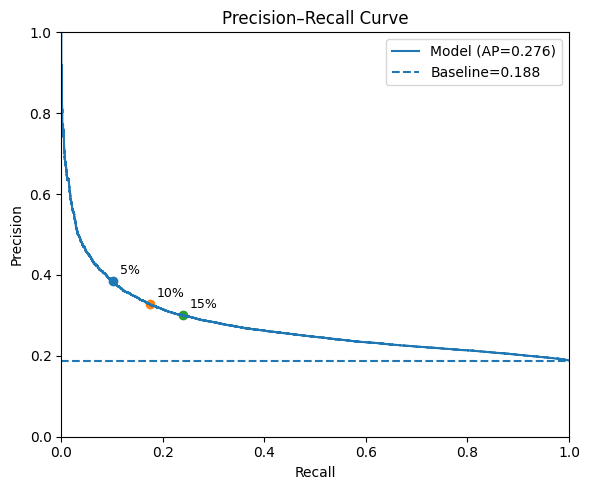

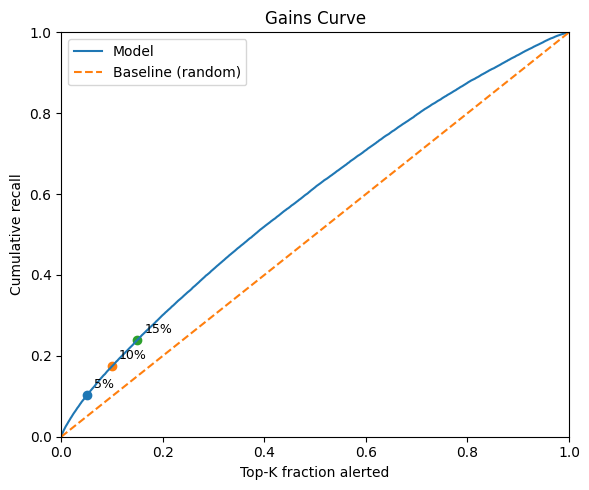

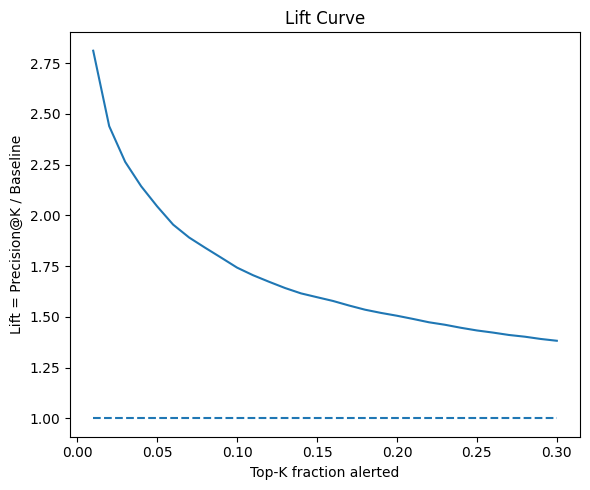

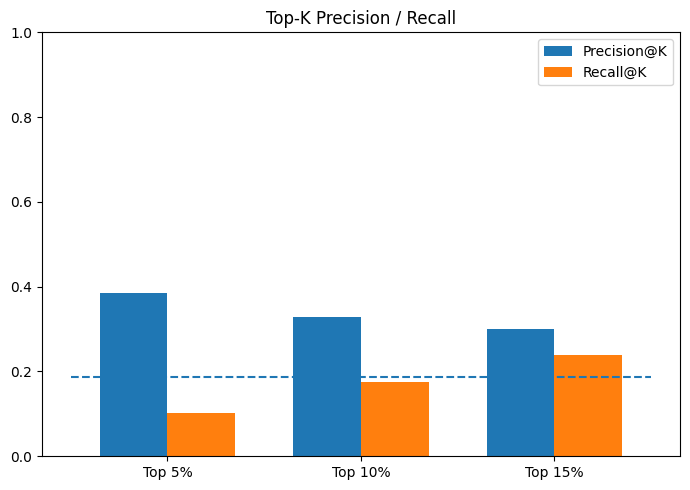


Top-K table:
    top_frac  alerts  threshold  precision@K  recall@K    lift@K
0      0.05   14831   0.635525     0.384330  0.102202  2.043912
1      0.10   29661   0.591203     0.327602  0.174227  1.742225
2      0.15   44491   0.564512     0.300218  0.239493  1.596594

[Top-10%] threshold=0.591203
Confusion matrix:
 [[220886  19944]
 [ 46055   9717]]

Classification report (Top-10%):
               precision    recall  f1-score        support
0              0.827471  0.917186  0.870022  240830.000000
1              0.327602  0.174227  0.227477   55772.000000
accuracy       0.777483  0.777483  0.777483       0.777483
macro avg      0.577537  0.545707  0.548749  296602.000000
weighted avg   0.733478  0.777483  0.749200  296602.000000


In [8]:
# ==== Plot kit for classification results (no seaborn; matplotlib only) ====
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix, classification_report

def _topk_metrics(y_true, y_score, ks=(0.05, 0.10, 0.15)):
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score, float)
    order = np.argsort(-y_score)
    pos = y_true.sum()
    base = y_true.mean()
    rows = []
    n = len(y_true)
    for k in ks:
        kk = max(1, int(np.ceil(k*n)))
        idx = order[:kk]
        tp = y_true[idx].sum()
        rec = tp / pos if pos > 0 else np.nan
        prec = tp / kk if kk > 0 else np.nan
        lift = prec / base if base > 0 else np.nan
        thr = y_score[order[kk-1]]
        rows.append({"top_frac": k, "alerts": kk, "threshold": thr,
                     "precision@K": prec, "recall@K": rec, "lift@K": lift})
    return pd.DataFrame(rows), base

def plot_pr(y_true, y_score, ks=(0.05,0.10,0.15), save_path="pr_curve.png"):
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score, float)
    prec, rec, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    base = y_true.mean()
    topk_tbl, _ = _topk_metrics(y_true, y_score, ks)

    plt.figure(figsize=(6,5))
    plt.plot(rec, prec, label=f"Model (AP={ap:.3f})")
    plt.hlines(base, 0, 1, linestyles="dashed", label=f"Baseline={base:.3f}")
    # 標注 Top-K 點
    for _, r in topk_tbl.iterrows():
        plt.scatter(r["recall@K"], r["precision@K"])
        plt.annotate(f"{int(r['top_frac']*100)}%", (r["recall@K"], r["precision@K"]),
                     xytext=(5,5), textcoords="offset points", fontsize=9)
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall Curve")
    plt.legend()
    plt.tight_layout(); plt.savefig(save_path, dpi=160); plt.show()

def plot_gains(y_true, y_score, ks=(0.05,0.10,0.15), save_path="gains_curve.png"):
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score, float)
    order = np.argsort(-y_score)
    y_sorted = y_true[order]
    cum_pos = np.cumsum(y_sorted)
    total_pos = y_true.sum()
    frac = (np.arange(1, len(y_true)+1))/len(y_true)
    gains = cum_pos / total_pos if total_pos>0 else np.zeros_like(cum_pos)

    plt.figure(figsize=(6,5))
    plt.plot(frac, gains, label="Model")
    plt.plot([0,1],[0,1], linestyle="dashed", label="Baseline (random)")
    # 標注 Top-K 點
    for k in ks:
        kk = max(1, int(np.ceil(k*len(y_true))))
        plt.scatter(frac[kk-1], gains[kk-1])
        plt.annotate(f"{int(k*100)}%", (frac[kk-1], gains[kk-1]),
                     xytext=(5,5), textcoords="offset points", fontsize=9)
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel("Top-K fraction alerted"); plt.ylabel("Cumulative recall")
    plt.title("Gains Curve"); plt.legend()
    plt.tight_layout(); plt.savefig(save_path, dpi=160); plt.show()

def plot_lift(y_true, y_score, ks=np.linspace(0.01,0.30,30), save_path="lift_curve.png"):
    tbl, base = _topk_metrics(y_true, y_score, ks=tuple(ks))
    plt.figure(figsize=(6,5))
    plt.plot(tbl["top_frac"], tbl["lift@K"])
    plt.hlines(1.0, tbl["top_frac"].min(), tbl["top_frac"].max(), linestyles="dashed")
    plt.xlabel("Top-K fraction alerted"); plt.ylabel("Lift = Precision@K / Baseline")
    plt.title("Lift Curve")
    plt.tight_layout(); plt.savefig(save_path, dpi=160); plt.show()
    return tbl

def plot_bar_topk(y_true, y_score, ks=(0.05,0.10,0.15), save_path="topk_bars.png"):
    tbl, base = _topk_metrics(y_true, y_score, ks)
    idx = np.arange(len(tbl))
    width = 0.35
    plt.figure(figsize=(7,5))
    plt.bar(idx - width/2, tbl["precision@K"], width, label="Precision@K")
    plt.bar(idx + width/2, tbl["recall@K"],    width, label="Recall@K")
    # 基準線（Precision 的基準 = 正例率）
    plt.hlines(base, -0.5, len(tbl)-0.5, linestyles="dashed")
    plt.xticks(idx, [f"Top {int(k*100)}%" for k in tbl["top_frac"]])
    plt.ylim(0,1)
    plt.title("Top-K Precision / Recall")
    plt.legend()
    plt.tight_layout(); plt.savefig(save_path, dpi=160); plt.show()
    return tbl

def topk_confusion_report(y_true, y_score, top_frac=0.10):
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score, float)
    k = max(1, int(np.ceil(top_frac * len(y_score))))
    thr = np.partition(y_score, -k)[-k]
    yhat = (y_score >= thr).astype(int)
    cm = confusion_matrix(y_true, yhat)
    rep = classification_report(y_true, yhat, digits=3, output_dict=True)
    rep_df = pd.DataFrame(rep).T
    return thr, cm, rep_df

# ==== Use it on your arrays ====
# Choose which score to plot:
y_true = np.asarray(yte)  # test labels
y_score = p_te_hgb if "p_te_hgb" in globals() else p_te  # model scores

print("Baseline positive rate (test) =", y_true.mean())

plot_pr(y_true, y_score, ks=(0.05,0.10,0.15), save_path="pr_curve.png")
plot_gains(y_true, y_score, ks=(0.05,0.10,0.15), save_path="gains_curve.png")
lift_tbl = plot_lift(y_true, y_score, ks=np.linspace(0.01,0.30,30), save_path="lift_curve.png")
topk_tbl = plot_bar_topk(y_true, y_score, ks=(0.05,0.10,0.15), save_path="topk_bars.png")
print("\nTop-K table:\n", topk_tbl)

thr, cm, rep_df = topk_confusion_report(y_true, y_score, top_frac=0.10)
print(f"\n[Top-10%] threshold={thr:.6f}")
print("Confusion matrix:\n", cm)
print("\nClassification report (Top-10%):\n", rep_df)